# Investigating Fandango Movie Ratings

[Fandango](https://www.fandango.com/)は有名な映画レビューサイトの１つであるが、2015年10月、データジャーナリストのWalt Hickeyの[記事](https://fivethirtyeight.com/features/fandango-movies-ratings/)によって、レビュー
値のインフレを行っていたことが発覚した。

本プロジェクトでは、Fandangoの近年(2014-17年)のレビューデータを分析し、Hickeyの記事以後、Fandangoのレビューシステムに変化があったかどうかを調べる。

# Understanding the Data

In [1]:
import pandas as pd
movie_ratings_14_15 = pd.read_csv('fandango_score_comparison.csv')
movie_ratings_16_17 = pd.read_csv('movie_ratings_16_17.csv')

print(movie_ratings_14_15.shape)
print(movie_ratings_16_17.shape)
print(movie_ratings_14_15.head())
print(movie_ratings_16_17.head())

(146, 22)
(214, 15)
                             FILM  RottenTomatoes  RottenTomatoes_User  \
0  Avengers: Age of Ultron (2015)              74                   86   
1               Cinderella (2015)              85                   80   
2                  Ant-Man (2015)              80                   90   
3          Do You Believe? (2015)              18                   84   
4   Hot Tub Time Machine 2 (2015)              14                   28   

   Metacritic  Metacritic_User  IMDB  Fandango_Stars  Fandango_Ratingvalue  \
0          66              7.1   7.8             5.0                   4.5   
1          67              7.5   7.1             5.0                   4.5   
2          64              8.1   7.8             5.0                   4.5   
3          22              4.7   5.4             5.0                   4.5   
4          29              3.4   5.1             3.5                   3.0   

   RT_norm  RT_user_norm         ...           IMDB_norm  RT_norm_

In [2]:
fand_14_15 = movie_ratings_14_15[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference'] ].copy()
fand_14_15.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [3]:
fand_16_17 = movie_ratings_16_17[['movie', 'year', 'fandango']].copy()
fand_16_17.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Hickeyの分析後、Fandangoの評価システムに変更があったかどうかを求めるのが目的である。この分析の対象となる母集団はFandangoのサイト上にある映画レビュー全てとし、さらに映画の公開年には関わらないとする。この母集団のパラメーターに変化があったかを調べるために、Hickeyの分析の前と後の２つの異なる期間で母集団をサンプリングして、それら２つの比較を行う。

分析を行う前に、与えられた2つのサンプルデータが定義した母集団から無作為抽出されたものであるかどうか調べる必要がある。母集団について述べていくことが目的であるので、標本は母集団からできるだけ偏りなく抽出されたものでなければならない。もし、偏りがある場合は、サンプリングエラーが大きくなり、間違った結論に着地する可能性がある。

Hickeyの記事と、データセットの[README.mb](https://github.com/fivethirtyeight/data/blob/master/fandango/README.md)から、彼の抽出法がわかる：

* 2015/08/24時点で、レビュー数が30以上の映画
* 2015年にチケットが販売されていた映画

以上から、レビュー数が30未満の映画や2015年にチケットが販売されていない映画が抽出の対象外であったことがわかる。したがって、彼のサンプリングは無作為抽出ではない。また、定義した母集団は公開年に関わらずサイト上の全ての映画を対象とするため、2015年の映画のみの標本からの推測は時間的バイアスを受けてしまうと考えられる。この標本は、定義した母集団の推測に適切ではない。

GitHubの[README.mb](https://github.com/mircealex/Movie_ratings_2016_17/blob/master/README.md)より、もう１つの標本の抽出法は以下の通りである：

* 2016年、2017年に公開された映画
* ある一定数（README.mbでは正確に言及されていない）のレビューが投稿された映画

以上より、この標本も求めたい母集団の推測には適さない。

# Changing the Goal of Analysis

2つの標本を用いて分析するためには、目標を少し変える必要がある。そこで、Hickeyの分析前後でFandangoのレビューシステムに変化があったかを調べるのではなく、Fandangoにおける2015年の人気映画のレビュー値と、2016年の人気映画のレビュー値の間に違いがあるかどうかを調べることにする。この新しい目標設定は、初めの設定の代わりとして十分であると考える。

# Isolating the Samples We need

新しい目標設定をした今、求めたい母集団は以下の２つである

* 2015年に公開され、Fandangoでレビューされている人気映画
* 2016年に公開され、Fandangoでレビューされている人気映画

ここで、人気映画の定義はHickey氏を参考に、レビュー数が30以上のものとする。

母集団の推測に適切であるためには、2つの標本内のほとんど全ての映画が「レビュー数30以上」を満たす必要がある。
まず、2015年の標本を確認する。

In [4]:
sum(movie_ratings_14_15["Fandango_votes"] < 30)

0

2015年の標本の映画は全て人気映画である。

次に、2016年の標本を調べる。このデータセットは各映画のレビュー数を含んでいないため、代わりの方法で確かめる必要がある。
標本の適性を調べる簡単な方法の１つは、10本の映画をランダムにサンプリングしてFandangoのサイトでレビュー数を確認することである。10本のうち少なくとも8本はレビュー数が30以上であることが望ましい。

In [5]:
movie_ratings_16_17.sample(n = 10, random_state = 1)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
108,Mechanic: Resurrection,2016,38,5.6,29,41,4.0,1.90,2.80,1.45,2.05,2.0,3.0,1.5,2.0
206,Warcraft,2016,32,7.0,28,71,4.0,1.60,3.50,1.40,3.55,1.5,3.5,1.5,3.5
106,Max Steel,2016,22,4.6,0,38,3.5,1.10,2.30,0.00,1.90,1.0,2.5,0.0,2.0
107,Me Before You,2016,51,7.4,58,73,4.5,2.55,3.70,2.90,3.65,2.5,3.5,3.0,3.5
51,Fantastic Beasts and Where to Find Them,2016,66,7.5,73,81,4.5,3.30,3.75,3.65,4.05,3.5,4.0,3.5,4.0
33,Cell,2016,38,4.3,11,16,3.0,1.90,2.15,0.55,0.80,2.0,2.0,0.5,1.0
59,Genius,2016,56,6.5,51,45,3.5,2.80,3.25,2.55,2.25,3.0,3.0,2.5,2.0
152,Sully,2016,74,7.5,85,85,4.5,3.70,3.75,4.25,4.25,3.5,4.0,4.0,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0
31,Captain America: Civil War,2016,75,7.9,90,89,4.5,3.75,3.95,4.50,4.45,4.0,4.0,4.5,4.5


無作為抽出した10本の映画の現在のレビュー数を[Fandango](https://www.fandango.com/)で調べた結果を表にまとめる

| タイトル|レビュー数 |
|---|---|
|Mechanic: Resurrection| 8,475|
| Warcraft|7,756|
|Max Steel|2,178|
|Me Before You|8,024|
|Fantastic Beasts and Where to Find Them|22,484|
|Cell|1,841|
|Genius|907|
|Sully|12,160|
|A Hologram for the King|2931|
|Captain America: Civil War|42,048|

10本全てが条件を満たしているため、この標本の適性は高いといえる。

2つの標本には2015年と2016年に公開されたものではない映画が含まれているため、必要なデータだけを抜き取る。

In [6]:
fand_14_15.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [7]:
fand_14_15['Year'] = fand_14_15['FILM'].str[-5:-1]
fand_14_15.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015


In [8]:
fand_14_15['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [9]:
fand_15 = fand_14_15[fand_14_15.Year == '2015'].copy()
fand_15['Year'].value_counts()

2015    129
Name: Year, dtype: int64

In [10]:
fand_16_17.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


In [11]:
fand_16_17['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [12]:
fand_16 = fand_16_17[fand_16_17['year'] == 2016].copy()
fand_16['year'].value_counts()

2016    191
Name: year, dtype: int64

# Comparing Distribution Shapes for 2015 and 2016

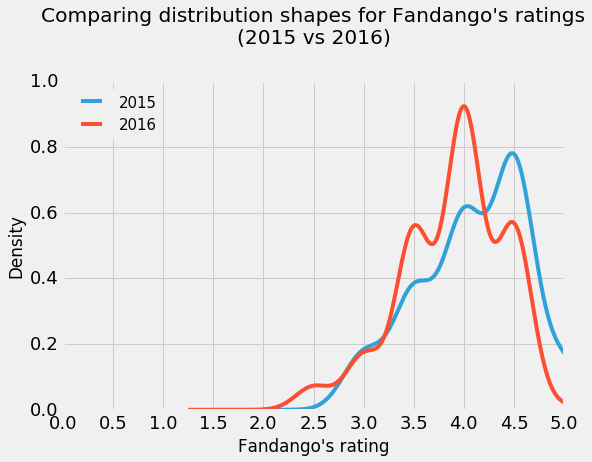

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('fivethirtyeight')

fand_15['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fand_16['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)", y = 1.1)
plt.ylabel('Density')
plt.xlabel("Fandango's rating")
plt.legend(loc='upper left', fontsize = 15)

plt.xlim(0, 5)
plt.xticks(np.arange(0, 5.1, 0.5))
plt.tick_params(labelsize = 18)
plt.show()

表から次のことが読み取れる：
* どちらのカーネル密度推定も左に裾が長い
* 2016年の分布は2015年に比べて左にシフトしている

まず１つ目から、Fandango上の映画の評価値が高いことがわかる。他の映画レビューサイトではあまり行われていないチケット販売を扱っていることが関係しているかは興味深い問題ではあるが、残念長ら本分析の目的ではない。

2つ目から、2016年のFandango上の人気映画のレビュー値は、2015年に比べて概して低くなっていることがわかる。

# Comparing Ralative Frequency

In [16]:
print(fand_15['Fandango_Stars'].value_counts().sort_index())
print(fand_16['fandango'].value_counts().sort_index())

3.0    11
3.5    23
4.0    37
4.5    49
5.0     9
Name: Fandango_Stars, dtype: int64
2.5     6
3.0    14
3.5    46
4.0    77
4.5    47
5.0     1
Name: fandango, dtype: int64


データのサンプル数が異なるため、百分率を用いて相対度数で比較する。

In [18]:
print('2015' + '\n' + '_' * 16)
fand_15['Fandango_Stars'].value_counts(normalize=1).sort_index() * 100

2015
________________


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [19]:
print('2016' + '\n' + '_' * 16)
fand_16['fandango'].value_counts(normalize=1).sort_index() * 100

2016
________________


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

2016年は高評価(4.5, 5.0)の割合が2015年に比べて低くなっている。2015年は星5が7％を、星4.5が37％を占めていたのに対して、2016年ではそれぞれ0.5％,24％と非常に低くなっている。

また、2015年には星2.5以下がひとつもなかったのに対して、2016年には星2.5が3％存在することがわかる。

以上のことから度数分布表からも、2016年のレビュー値は2015年に比べて低くなっていることといえる。

# Determining the Direction of Change

平均値、中央値、最頻値を計算し、これらが２つの標本の分布の違いについて示唆するものがあるかどうか調べる

In [27]:
mean_2015 = fand_15["Fandango_Stars"].mean()
mean_2016 = fand_16["fandango"].mean()

median_2015 = fand_15["Fandango_Stars"].median()
median_2016 = fand_16["fandango"].median()

mode_2015 = fand_15["Fandango_Stars"].mode()[0]
mode_2016 = fand_16["fandango"].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


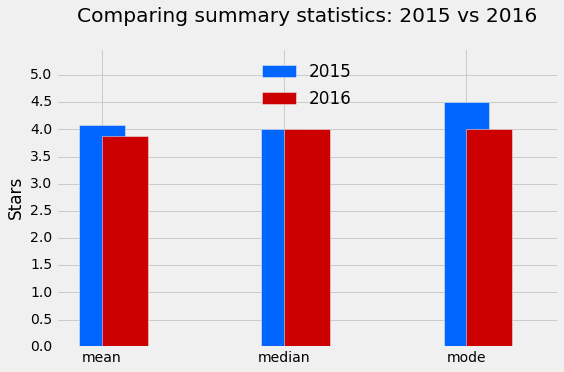

In [29]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

In [30]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0]

0.04842683568951993

2016年の平均値は2015年から約5％小さくなっている。中央値はどちらも4.0である。最頻値は2016年の方が小さい。

これまでの分析から、2016年のレビュー値は2015年に比べてわずかに低くなっていると結論づけることができる。
この変化の原因を確証することはできないが、Hickey氏の分析後にFan